In [ ]:
# default_exp core

# CCLDDG Core Class
> Defining the key UNet and Discriminator architectures used.

I've tried to make this as informative as possible :)

I should mention that I started with code from [the labml annotated DDPM paper](https://github.com/labmlai/annotated_deep_learning_paper_implementations/tree/master/labml_nn/diffusion/ddpm), so credit there! It's a great resource.

In [ ]:
#hide
from nbdev.showdoc import *
from matplotlib import pyplot as plt

In [ ]:
#export
import math
from typing import Optional, Tuple, Union, List
import torch
from torch import nn

## Building Blocks

This section defines the different building blocks we'll use to build the core unet and discriminator architectures.

### The activation function:

By default this all uses the `Swish` activation function: $x \cdot \sigma(x)$

In [ ]:
#export
class Swish(nn.Module):
    """ *swish...* """
    def forward(self, x):
        return x * torch.sigmoid(x)

You can think of this as 'fancy ReLU'... This is what it looks like:

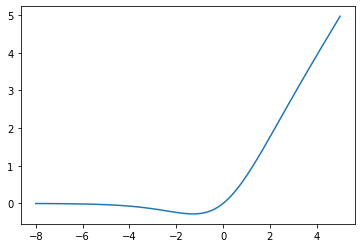

In [ ]:
#collapse
swish = Swish()
x = torch.linspace(-8, 5, 100)
y = swish(x)
plt.plot(x, y)
plt.show()

### Embeddings

Next, we want a way to create embeddings from various conditioning information.

In [ ]:
#export

# The time embedding 
class TimeEmbedding(nn.Module):
    """ Embeddings for $t$ """

    def __init__(self, n_channels: int, denom_factor=10000):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        self.denom_factor = denom_factor
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor, return_sinusoidal_embs=False):
        """ Create sinusoidal position embeddings as used in many transformers. """
        half_dim = self.n_channels // 8
        emb = math.log(self.denom_factor) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        
        if return_sinusoidal_embs:
            return emb
        

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb

The Positional Embedding used for `TimeEmbedding` is a sinusoidal embedding as used in many transformer implementations:
$$
\begin{align}
PE^{(1)}_{t,i} &= sin\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg) \\
PE^{(2)}_{t,i} &= cos\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg)
\end{align}
$$

where $d$ is `half_dim` = `n_channels//8`

Since we expect to encode only a small number of steps we can specify a smaller multiplier than 10000 using the `denom_factor` argument.

These sinusoidal embeddings are usually then passed through an MLP to transform them into n_channels outputs, but we can pass in `return_sinusoidal_embs=True` to get the raw sinusoidal embeddings for visualization purposes. Here's an example visualizing this for t in range(0, 10):

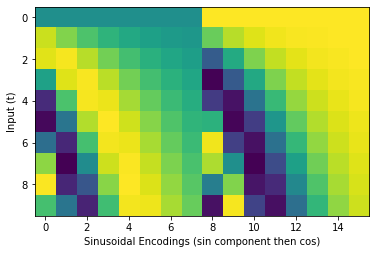

In [ ]:
#collapse
te = TimeEmbedding(n_channels=64, denom_factor=16)
t = torch.arange(0, 10)
embs = te(t, return_sinusoidal_embs=True)
embs.shape
plt.imshow(embs.detach(), )
plt.xlabel('Sinusoidal Encodings (sin component then cos)')
plt.ylabel('Input (t)')
plt.show()

We also create embeddings to map a latent variable `z` and our CLOOB embedding to set numbers of channels. Both simply run the input through a small MLP to map them to `n_channels` outputs. 

In [ ]:
#export
# CLOOB embedding
class CLOOBEmbedding(nn.Module):
    """ Embedding to map a CLOOB embedding (512 dimensions) to n_channels via an MLP """
    def __init__(self, n_channels: int):
        super().__init__()
        self.n_channels = n_channels
        self.lin1 = nn.Linear(512, self.n_channels)
        self.act = Swish()
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, emb):
        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)
        return emb

# One for the gan latent, z
class ZEmbedding(nn.Module):
    """ Embedding to map a latent z (`z_dim` dimensions) to n_channels via an MLP """
    def __init__(self, z_dim:int, n_channels: int):
        super().__init__()
        self.n_channels = n_channels
        self.z_dim = z_dim
        self.lin1 = nn.Linear(z_dim, self.n_channels)
        self.act = Swish()
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, emb):
        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)
        return emb
    



### Additional Components

The rest of the building blocks are fairly standard, but all here take both an input (x) and some conditioning (cond). 

In [ ]:
#export
# Residual blocks include 'skip' connections
class ResidualBlock(nn.Module):
    """
    ### Residual block
    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, n_cond_channels: int, n_groups: int = 32):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for conditional embeddings
        self.cond_emb = nn.Linear(n_cond_channels, out_channels)

    def forward(self, x: torch.Tensor, cond: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.cond_emb(cond)[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.act2(self.norm2(h)))

        # Add the shortcut connection and return
        return h + self.shortcut(x)

# Ahh yes, magical attention...
class AttentionBlock(nn.Module):
    """
    ### Attention block
    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, cond: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `cond` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = cond
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=1)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


class DownBlock(nn.Module):
    """
    ### Down block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, cond: torch.Tensor):
        x = self.res(x, cond)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):
    """
    ### Up block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, n_cond_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, n_cond_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, cond: torch.Tensor):
        x = self.res(x, cond)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):
    """
    ### Middle block
    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, n_cond_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, n_cond_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, n_cond_channels)

    def forward(self, x: torch.Tensor, cond: torch.Tensor):
        x = self.res1(x, cond)
        x = self.attn(x)
        x = self.res2(x, cond)
        return x


class Upsample(nn.Module):
    """
    ### Scale up the feature map by 2.
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, cond: torch.Tensor):
        # `cond` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = cond
        return self.conv(x)


class Downsample(nn.Module):
    """
    ### Scale down the feature map by 0.5
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, cond: torch.Tensor):
        # `cond` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = cond
        return self.conv(x)



## The UNet and Discriminator

This is what we've been building up to. We want a UNet mode that can take in a (noisy) image or image-like tensor, along with some conditioning information (timestep, CLOOB embedding) and optionally a latent `z`, and produce an output of the same shape as the input.

In [ ]:
#export

# The core class definition (aka the important bit)
class UNet(nn.Module):
    """
    #### U-Net
    
    Hopefully flexible enough :) Arguments:
    
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        * `use_z`=True. Set to false if you don't want to include the latent z input
        * `z_dim` is the dimension of the latent `z`, and `n_z_channels` is the size of the embedding used for it.
        * `use_cloob` = True. Set to false if you don't want to use CLOOB conditioning.
        * `n_cloob_channels` - the size of the embedding used for the CLOOB conditioning input.
        * `n_time_channels` - the size of the time embedding. If -1, this is set to n_channels*4
        * `denom_factor` for the TimeEmbedding. 100 by default, set to 10,000 if wanting to do more traditional diffusion stuff where n_steps is high.
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2,
                 use_z=True,z_dim: int = 8, n_z_channels: int=16,
                 use_cloob=True, n_cloob_channels: int = 256,
                 n_time_channels: int=-1,
                 denom_factor: int=100):
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))


        # Time embedding layer. Time embedding has `n_channels * 4` channels in the original paper, with demon_factor=10,000
        n_time_channels = n_channels * 4
        self.time_emb = TimeEmbedding(n_time_channels, denom_factor=denom_factor)
        
        # CLOOB embeddings
        self.use_cloob = use_cloob
        self.cloob_emb = CLOOBEmbedding(n_cloob_channels)

        # Z embeddings
        self.use_z = use_z
        self.z_emb = ZEmbedding(z_dim=z_dim, n_channels=n_z_channels)
        
        n_cond_channels = n_time_channels
        if use_cloob:
            n_cond_channels += n_cloob_channels
        if use_z:
            n_cond_channels += n_z_channels
        
        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_cond_channels, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_cond_channels, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_cond_channels, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_cond_channels, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor, c=None, z=None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        * `c` is cloob embeddings shape [batch_size, 512]
        * `z` is latent input shape [batch_size, z_dim]
        """
        
        # The combined embeddings become our conditioning info (n_cond_channels total) fed in at various stages.
        # Starting with the time-step embeddings
        t = self.time_emb(t)
        cond = t
        
        # Combine with the cloob & z embeddings (if applicable)
        if self.use_cloob:
            if c==None:
                c = torch.zeros((x.shape[0], 512)).to(t.device)
            c = self.cloob_emb(c)
            cond = torch.cat((cond, c), dim=1)
        if self.use_z:
            if z==None:
                z = torch.zeros((x.shape[0], self.z_emb.z_dim)).to(t.device)
            z = self.z_emb(z)
            cond = torch.cat((cond, z), dim=1)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, cond)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, cond)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, cond)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                # Add in conditioning
                x = m(x, cond)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))
    
    


We'd also like a Discriminator that can take in an image, with the same optional conditioning information, and spit out a classification (real or fake). If you want to condition the discriminator on another image (e.g. in DDG the discriminator takes in $x_{t-1}$ and is conditioned on $x_t$) then simply concatenate them together and use `image_channels = 2*[the number of channels in a single image]`.

In [ ]:
#export
class Discriminator(nn.Module):
    """
    
    #### Discriminator
    
    Based on the same architecture as the UNet, but without the upwards half. Arguments:
    
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        * `use_cloob` = True. Set to false if you don't want to use CLOOB conditioning.
        * `n_cloob_channels` - the size of the embedding used for the CLOOB conditioning input.
        * `n_time_channels` - the size of the time embedding. If -1, this is set to n_channels*4
        * `denom_factor` for the TimeEmbedding. 100 by default, set to 10,000 if wanting to do more traditional diffusion stuff where n_steps is high.
    
    """
    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2,
                 use_cloob=True, n_cloob_channels: int = 256,
                 n_time_channels: int=-1,
                 denom_factor: int=100):
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

       # Time embedding layer. Time embedding has `n_channels * 4` channels in the original paper, with demon_factor=10,000
        n_time_channels = n_channels * 4
        self.time_emb = TimeEmbedding(n_time_channels, denom_factor=denom_factor)
        
        # CLOOB embeddings
        self.use_cloob = use_cloob
        self.cloob_emb = CLOOBEmbedding(n_cloob_channels)
        
        n_cond_channels = n_time_channels
        if use_cloob:
            n_cond_channels += n_cloob_channels
        
        # #### First half (same as Unet)- decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_cond_channels, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_cond_channels, )

        # Final 'head'
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(out_channels, 1), # TODO add a second MLP layer here maybe?
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor, c=None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        * `c` is cloob embeddings shape [batch_size, 512]
        """

       # The combined embeddings become our conditioning info (n_cond_channels total) fed in at various stages.
        # Starting with the time-step embeddings
        t = self.time_emb(t)
        cond = t
        
        # Combine with the cloob if applicable
        if self.use_cloob:
            if c==None:
                c = torch.zeros((x.shape[0], 512))
            c = self.cloob_emb(c)
            cond = torch.cat((cond, c), dim=1)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, cond)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, cond)

        return self.head(x) # Final output

Let's see both in action:

In [ ]:
device = 'cpu'
unet = UNet(image_channels=4).to(device)
z = torch.randn((1,8), device=device)
c = torch.zeros((1,512), device=device)
x = torch.randn(1, 4, 16, 16).to(device)
t = torch.tensor(3, dtype=torch.long).unsqueeze(0).to(device)
pred_im = unet(x.float(), t, c, z)
x.shape, pred_im.shape

(torch.Size([1, 4, 16, 16]), torch.Size([1, 4, 16, 16]))

In [ ]:
disc = Discriminator(image_channels=4, use_cloob=False)
disc(x, t).shape

torch.Size([1, 1])

In [ ]:
labels = torch.tensor([1]).float()
criterion = nn.BCELoss()
criterion(disc(x, t).view(-1), labels)

tensor(0.6967, grad_fn=<BinaryCrossEntropyBackward0>)